In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import cleverhans
from cleverhans.attacks import FastGradientMethod, MadryEtAl, MomentumIterativeMethod
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from cleverhans.utils_keras import KerasModelWrapper
from keras.applications.imagenet_utils import preprocess_input
from cleverhans.model import EnsembleWrapper
from keras.layers.core import Lambda
from keras.layers import Input
import numpy as np
import tensorflow as tf
from keras.layers import Input
from keras.models import Model
from keras.layers import Average
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
alpha = 300.0
clip_min = 0.0
clip_max = 255.0

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(config=config) as sess:
    input_tensor = Input(shape=(224, 224, 3))
    tf_inputs = Lambda(lambda x: preprocess_input(x, mode='tf'))(input_tensor)
    caffe_inputs = Lambda(lambda x: preprocess_input(x, mode='caffe'))(input_tensor)
    print "starting to load models"
    base_inception = InceptionV3(input_tensor=input_tensor, weights="imagenet", include_top=True)
    inception = Model(inputs=input_tensor, outputs=base_inception(tf_inputs))

#     base_densenet = DenseNet121(input_tensor=input_tensor, weights="imagenet", include_top=True)
#     densenet = Model(inputs=input_tensor, outputs=base_densenet(tf_inputs))

#     base_resnet = ResNet50(input_tensor=input_tensor, weights="imagenet", include_top=True)
#     resnet = Model(inputs=input_tensor, outputs=base_resnet(caffe_inputs))

#     base_vgg = VGG16(input_tensor=input_tensor, weights="imagenet", include_top=True)
#     vgg = Model(inputs=input_tensor, outputs=base_vgg(caffe_inputs))

#     base_xception = Xception(input_tensor=input_tensor, weights="imagenet", include_top=True)
#     xception = Model(inputs=input_tensor, outputs=base_xception(tf_inputs))
    
#     models = [inception, xception, resnet, densenet, vgg]
    models = [inception]

    for model in models:
        model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    print "finished compiling models"
    X_exp = np.load('dl_experiments_data/imagenet/X_exp.npy')[:100]
    Y_exp = np.load('dl_experiments_data/imagenet/Y_exp.npy')[:100]
    
    models = [EnsembleWrapper(model) for model in models]
    
    model_attacks = []
    
    for i, model in enumerate(models):
        print "Model ", i
        fgm = FastGradientMethod(model, sess=sess)
        madry = MadryEtAl(model, sess=sess)
        mim = MomentumIterativeMethod(model, sess=sess)
        
        fgm_params = {'eps': alpha,
                      'clip_min': clip_min,
                      'clip_max': clip_max,
                      'ord': 2,
                      'y': Y_exp}
        print "FGM"
        adv_fgm = fgm.generate_np(X_exp, **fgm_params)

        madry_params = {'eps': alpha,
                        'eps_iter': alpha / 40.0 * 1.25,
                        'nb_iter': 40,
                        'clip_min': clip_min,
                        'clip_max': clip_max, 
                        'ord': 2,
                        'y': Y_exp}
        print "Madry"
        adv_madry = madry.generate_np(X_exp, **madry_params)

        mim_params = {'eps': alpha,
                      'eps_iter': alpha / 5.0,
                      'nb_iter': 5,
                      'clip_min': clip_min,
                      'clip_max': clip_max, 
                      'ord': 2, 
                      'decay_factor': 1.0,
                      'y': Y_exp}
        print "MIM"
        adv_mim = mim.generate_np(X_exp, **mim_params)
        
        model_attacks.append([adv_fgm, adv_mim])

In [ ]:
len(model_attacks)

In [ ]:
input_tensor = Input(shape=(224, 224, 3))
tf_inputs = Lambda(lambda x: preprocess_input(x, mode='tf'))(input_tensor)
caffe_inputs = Lambda(lambda x: preprocess_input(x, mode='caffe'))(input_tensor)
print "starting to load models"
base_inception = InceptionV3(input_tensor=input_tensor, weights="imagenet", include_top=True)
inception = Model(inputs=input_tensor, outputs=base_inception(tf_inputs))

In [ ]:
inception.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
attacks= model_attacks[0]

In [ ]:
inception.evaluate(X_exp, Y_exp)

In [ ]:
[inception.evaluate(attack, Y_exp)[1] for attack in attacks]

In [ ]:
dim = 224 * 224 * 3
normal_noise = np.random.normal(0, 10000 / np.sqrt(dim), (100, 224, 224, 3))
[inception.evaluate(np.clip(attack + normal_noise, clip_min, clip_max), Y_exp)[1] for attack in attacks]

In [ ]:
def multiple_round_acc(model, X, Y, std_dev, rounds):
    print "rounds ", rounds
    pred_list = []
    dim = 224 * 224 * 3
    clip_min = 0.0
    clip_max = 255.0
    for i in xrange(rounds):
        noise = np.random.uniform(-std_dev, std_dev, (100, 224, 224, 3))
#         normal_noise = np.random.normal(0, std_dev / np.sqrt(dim), (100, 224, 224, 3))
        preds = model.predict(np.clip(X + noise, clip_min, clip_max))
        preds = np.argmax(preds, axis=1)
        pred_list.append(preds)
    pred_list = np.array(pred_list)
    print pred_list[:,:10]
    return np.mean(mode(pred_list).mode == np.argmax(Y, axis=1))

In [ ]:
from PIL import Image

In [8]:
X_exp = np.load('dl_experiments_data/imagenet/X_exp.npy')[:100]

In [3]:
X_exp = np.load('dl_experiments_data/mnist/X_exp.npy')[:100]

In [10]:
X_exp[0] /255.0

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.6313726 , 0.5803922 , 0.5176471 ],
        [0.8509804 , 0.8       , 0.7372549 ],
        [0.7411765 , 0

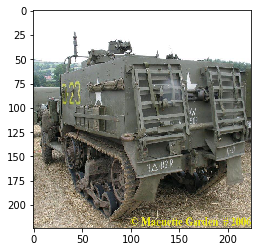

In [11]:
plt.imshow(X_exp[0]/ 255.0)

In [ ]:
Image.fromarray(X_exp[0])

In [ ]:
np.argmax(Y_exp[5])

In [ ]:
Y_exp.shape

In [ ]:
for rounds in [1,5,15]:
    print multiple_round_acc(inception, attacks[1], Y_exp, 35, rounds)
    print "DONE"

In [ ]:
fgm_acc_smooth = [model.evaluate(np.clip(adv_fgm + normal_noise, 0, 1), Y_exp)[1] for model in models]
madry_acc_smooth = [model.evaluate(np.clip(adv_madry + normal_noise, 0, 1), Y_exp)[1] for model in models]
mim_acc_smooth = [model.evaluate(np.clip(adv_fgm + normal_noise, 0, 1), Y_exp)[1] for model in models]

In [ ]:
multiple_round_acc(inception, X_exp, Y_exp, .1, 10)

In [ ]:
np.eye(5)[:2]